# Demo 4

This week we will use deep learning to classify land use and land cover (LULC) in the EuroSAT dataset (Helber et al., 2023). The dataset contains of 27,000 labeled Sentinel-2 images over Europe with ten different land use and land cover classes. The paper can be accessed [here](https://ieeexplore.ieee.org/document/8736785) and the dataset can be accessed [here](https://zenodo.org/records/7711810). We will just be using the RGB version so download the `EuroSAT_RGB.zip` file.

## Install packages

We will use [TensorFlow](https://www.tensorflow.org/) to construct a deep learning model. TensorFlow is a popular open-source machine learning framework developed by Google in 2015. TensorFlow provides a comprehensive ecosystem of tools, libraries, and community resources that support a wide range of tasks, from simple linear regression to complex neural networks. For beginners, TensorFlow offers high-level APIs like Keras, which simplify the process of building and training deep learning models.

Installation instructions are based on the [TensorFlow installation page](https://www.tensorflow.org/install). To install, open up a terminal and run the following commands:

```
conda create --name tf
```

Activate the environment

```
conda activate tf
```

Install TensorFlow

```
pip install tensorflow
```

Install some other useful packages
```
pip install jupyter scikit-learn matplotlib
```

Start Jupyter Lab
```
jupyter lab
```

## Import packages

In [44]:
# Import packages
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import itertools
import PIL
from sklearn.metrics import confusion_matrix

In [45]:
# Import Tensorflow packages for building the ResNet-50 model
import tensorflow.python.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [46]:
# Check version
tf.__version__

'2.19.0'

## Define training and test data

We will start by defining the characteristics of our data which we can do by loading one image. 

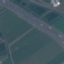

In [58]:
# Open one image file
image = PIL.Image.open('data/EuroSAT_RGB/Highway/Highway_5.jpg')
image

In [80]:
print(image.height, image.width)

64 64


In [61]:
print(image.getextrema())

((40, 231), (65, 222), (79, 217))


It looks like our data are 8-bit (i.e. have values between 0-255). For machine learning, a common practice is to normalize the values to a range between 0 and 1 which we can do by setting rescale to `1/255`.

In [57]:
# Normalize
rescale = 1.0/255

Now we define some other variables. Note that `validation_split` is the proportion of images that will be held out for testing purposes. 

In [62]:
dataset_url = 'data/EuroSAT_RGB/'
batch_size = 32
validation_split = 0.2

TensorFlow has some useful functions for generating training and testing datasets directly from our data directory. The directory structure has to be:

```
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
```

In [63]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split, rescale=rescale)
dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_url, image_size=(image.height, image.width), batch_size=batch_size)

Found 27000 files belonging to 10 classes.


Once we have these, we can print the class names by running

In [76]:
dataset.class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [65]:
# Define training dataset
train_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(image.height, image.width),
                                           subset="training",
                                           class_mode='categorical')

Found 21600 images belonging to 10 classes.


In [66]:
# Define testing dataset
test_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(image.height, image.width),
                                           subset="validation",
                                           class_mode='categorical')

Found 5400 images belonging to 10 classes.


## Visualize input datasets

2025-04-08 15:19:18.231895: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


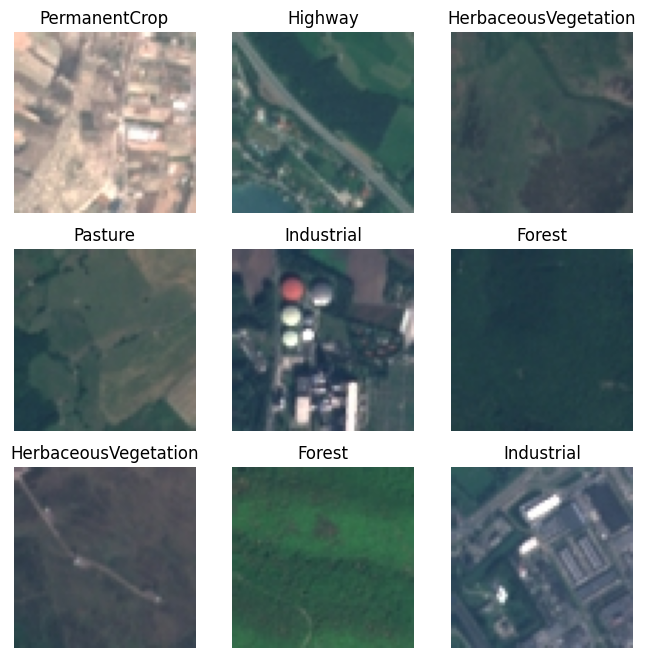

In [67]:
class_names = dataset.class_names
plt.figure(figsize=(8, 8))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Build ResNet-50 model

OK now let's start building a model. We are going to use ResNet-50 which is type of convolutional neural network (CNN) defined by He et al. (2016). ResNet-50 is a variant of the popular `ResNet` architecture, which stands for “Residual Network.” The “50” in the name refers to the number of layers in the network. ResNet-50 gained significant recognition by winning several visual recognition challenges including the the [ImageNet Large Scale Visual Recognition Challenge (ILSVRC)](https://www.image-net.org/challenges/LSVRC/). Since then, it has become a foundational model in the field of computer vision, widely used for various applications, including object detection and image segmentation.

In [10]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value.
    X_shortcut = X
    cache = []
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = X = Activation('relu')(X, training = training)

    return X

In [11]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [12]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
   # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

## Train model

After defining the model, we can compile it by specifying an [`optimizer`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers#classes) and [`loss`](https://www.tensorflow.org/api_docs/python/tf/keras/losses) argument. TensorFlow provides lots of different options but, to be as similar to Helber et al. (2023), we will use the **SGD** optimizer and the **categorical cross-entropy** loss function.  Definitions of `epochs` and `batch_size` can be found on the [Keras FAQ page](https://keras.io/getting_started/faq/#what-do-sample-batch-and-epoch-mean).

In [100]:
# Define model
model = ResNet50(input_shape=(image.height, image.width, 3), classes=10)

# Define the optimizer with a specific learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

# Compile model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(train_dataset, validation_data=test_dataset, epochs=3, batch_size=32)

Epoch 1/3
675/675 ━━━━━━━━━━━━━━━━━━━━ 312s 455ms/step - accuracy: 0.3038 - loss: 1.9989 - val_accuracy: 0.4700 - val_loss: 1.4562
Epoch 2/3
675/675 ━━━━━━━━━━━━━━━━━━━━ 361s 534ms/step - accuracy: 0.5561 - loss: 1.2617 - val_accuracy: 0.4524 - val_loss: 1.6788
Epoch 3/3
675/675 ━━━━━━━━━━━━━━━━━━━━ 372s 552ms/step - accuracy: 0.6510 - loss: 0.9746 - val_accuracy: 0.6048 - val_loss: 1.1497


````{margin}
```{note}
More epochs will improve the accuracy. Helber et al. (2021) for example used 120 epochs in their training (see [Table III](https://ieeexplore.ieee.org/document/8736785)) and achieved an overall accuracy of 98.6%.
```
````

```{note}
Now would be a good time to go and get a cup of tea
```

In [86]:
# Save model
model.save('model/resnet-50-epoch-3-model.keras')

## Load model

In [87]:
model = load_model('model/resnet-50-epoch-3-model.keras')

## Confusion matrix

In [88]:
y_pred = []  # predicted labels
y_true = []  # true labels

# Iterate over the dataset
for i, (image_batch, label_batch) in enumerate(test_dataset):
    
    # Append true labels
    y_true.append(label_batch)
    
    # Compute predictions
    preds = model.predict(image_batch, verbose=0)
    
    # Append predicted labels
    y_pred.append(np.argmax(preds, axis =  1))
    if i==300:
        break

# Convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

# Define confusion matrix
cm = confusion_matrix(correct_labels, predicted_labels)

## Plot confusion matrix

Text(0.5, -24.902777777777843, 'Predicted label')

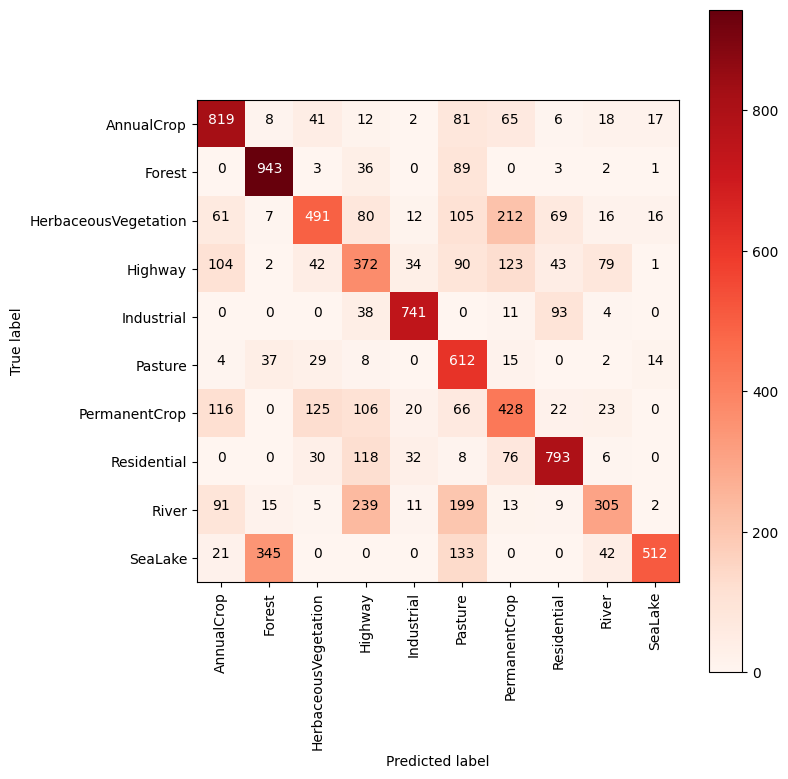

In [96]:
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap='Reds')
plt.colorbar()
tick_marks = np.arange(len(train_dataset.class_indices))
plt.xticks(tick_marks, train_dataset.class_indices, rotation=90)
plt.yticks(tick_marks, train_dataset.class_indices)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

## Some questions

1. What is the distribution of the training dataset? Is there any evidence of class imbalances?

2. 

## References

He, K., Zhang, X., Ren, S., & Sun, J. (2016). [Deep residual learning for image recognition](https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html). In Proceedings of the IEEE conference on computer vision and pattern recognition, 770-778.

Helber, P., Bischke, B., Dengel, A., & Borth, D. (2019). [EuroSAT: A novel dataset and deep learning benchmark for land use and land cover classification](https://ieeexplore.ieee.org/document/8736785). IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 12(7), 2217-2226.

Kshetri, T. (2024). [Deep Learning Application for Earth Observation](https://github.com/iamtekson/deep-learning-for-earth-observation/blob/main/Notebooks/01.%20image-classification/lulc_classification_euroSAT.ipynb).